<a href="https://colab.research.google.com/github/DeemOne-personal/Python-lessons/blob/main/homework_1_boosting_and_explanation_source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1
## Gradient boosting on temporal data and feature importances

https://github.com/v-goncharenko/madmo-21-07/blob/master/homeworks/homework_1_boosting_and_explanation.ipynb

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to. __Please, use [`shap`](https://github.com/slundberg/shap) and interpret the generated plots (with a brief summary).__

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Preprocessing.
The preprocessing is done for you. Let's take a look at the data.

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#added
from google.colab import drive
drive.mount('/content/drive')
import numpy as np

Mounted at /content/drive


In [4]:
X_train = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/train/X_train.txt')
y_train = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/train/y_train.txt')

X_test = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/test/X_test.txt')
y_test = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/test/y_test.txt')

with open('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/activity_labels.txt', 'r') as file:
    activity_labels = file.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

Lets look at the values we want to predict:

In [4]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [5]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [6]:
unique_columns = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

In [7]:
#measuring of how does slicing affects on the matrix
print('num of the unique columns to apply: '+str(len(unique_columns)))
print('initial matrix size:' + str(X_train.shape))
print('matrix size after filtering unique columns: '+ str(X_train_unique.shape))

num of the unique columns to apply: 540
initial matrix size:(7352, 561)
matrix size after filtering unique columns: (7352, 540)


Result is: number of columns (features) decreased 561 -> 540

In [ ]:
#just 4 test how slicing works on matrix
array = np.arange(75).reshape(5,5,3)
array[:,[0,1,2]]
print(array.shape)


In [ ]:
#https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
from sklearn.preprocessing import StandardScaler
print(array)
array = np.arange(20).reshape(5,4)
array_scaled = StandardScaler().fit_transform(array)
print('***********')
print(array_scaled)
pca =PCA(2)
array_PCA = pca.fit_transform(array_scaled)
print('***********')
print(array_PCA)

PCA could be useful in this case. E.g.

Added more information:

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [11]:
pca = PCA(0.8)
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)
print('train: '+str(X_train_pca.shape))
print('test: '+str(X_test_pca.shape))

train: (7352, 27)
test: (2947, 27)


Text(0, 0.5, 'Principal component 2')

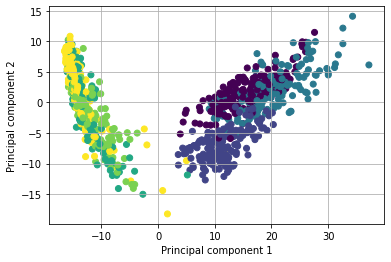

In [72]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

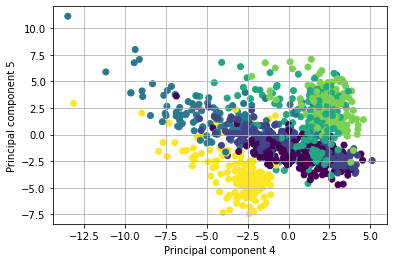

In [73]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some hyperparams by hand.

Example: https://rpubs.com/burakh/har_xgb

Docs: https://xgboost.readthedocs.io/en/latest/parameter.html

Params: https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

Additional info:

https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349

https://www.kaggle.com/dansbecker/xgboost




In [177]:
#SKLEARN API
#https://xgboost.readthedocs.io/en/latest/
### Example: https://rpubs.com/burakh/har_xgb

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

def train_model(X, y, params):
  
  print("X shape is:" + str(X.shape))
  print("y shape is:" + str(y.shape))

  #Data wrapper for XGBoost
  #dtrain = xgb.DMatrix(train_x, label=train_y)
  #dvalid = xgb.DMatrix(valid_x, label=valid_y)

  model = XGBClassifier(**params)
  print(model.get_xgb_params())

  #fit is SKlearn-compatible methon without encode to xgb.DMatrix
  model.fit(X, y)
  score = model.score(X, y)
  print("Accuracy @ train: {}".format(score))
  
  return model

def test_model(X, y, model):

  # predict the target on the train dataset
  y_preds = model.predict(X)
  print('\nPredictions are: ', y_preds) 

  # classification report 
  score = model.score(X, y)  
  print("Accuracy @ test: {}".format(score))

  print("Classification report:")
  print(classification_report(y, y_preds))

In [181]:
#TRAIN WITH DEFAULT PARAMS
model=train_model(X_train_pca, y_train, {})
test_model(X_test_pca, y_test, model)

X shape is:(7352, 27)
y shape is:(7352,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}
Accuracy @ train: 0.9464091403699674

Predictions are:  [5. 5. 5. ... 1. 2. 1.]
Accuracy @ test: 0.8615541228367831
Classification report:
              precision    recall  f1-score   support

         1.0       0.84      0.93      0.88       496
         2.0       0.89      0.93      0.91       471
         3.0       0.88      0.73      0.80       420
         4.0       0.79      0.75      0.77       491
         5.0       0.79      0.87      0.83       532
         6.0       0.99      0.94      0.97       537

    accuracy                           0.86      294

In [183]:
#TRAIN WITH PARAMS
params = {'objective':'binary:logistic', 'n_estimators':100, 'learning_rate':1, 'max_depth':8, 'subsample':1}
model=train_model(X_train_pca, y_train, params)
test_model(X_test_pca, y_test, model)

X shape is:(7352, 27)
y shape is:(7352,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}
Accuracy @ train: 1.0

Predictions are:  [5. 5. 5. ... 2. 2. 1.]
Accuracy @ test: 0.8751272480488632
Classification report:
              precision    recall  f1-score   support

         1.0       0.87      0.95      0.91       496
         2.0       0.88      0.91      0.90       471
         3.0       0.88      0.76      0.82       420
         4.0       0.81      0.79      0.80       491
         5.0       0.82      0.87      0.84       532
         6.0       0.99      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg   

In [185]:
#Watch config
import subprocess
#CPU/RAM
#print((subprocess.check_output("lscpu", shell=True).strip()).decode())

#CHECK WHETHER IS CUDA PRESENTING
#NO CUDA :(
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [159]:
#old way
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3                
                    )

grid.fit(X_train_pca, y_train)

KeyboardInterrupt: ignored

Interpret

In [ ]:
https://www.kaggle.com/shahules/xgboost-feature-selection-dsbowl/

https://www.kaggle.com/dansbecker/xgboost

https://neptune.ai/blog/how-to-organize-your-xgboost-machine-learning-ml-model-development-process

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py

https://www.kaggle.com/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna/comments

https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407

In [ ]:
!pip install optuna 
import optuna

In [270]:
#new way
import numpy as np
import optuna
from  sklearn.metrics import mean_squared_error
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

def objective(trial, X_train=X_train_pca,y_train=y_train, X_test=X_test_pca, y_test=y_test):    
    
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process, not works in Colab
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        #'gamma': trial.suggest_categorical('gamma', [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]) #added later, extremely slows down key finding with little effect on acc
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    model = xgb.XGBRegressor(**param)     
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)    
    preds = model.predict(X_test)    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse

In [271]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
result=study.trials_dataframe()

[I 2021-07-22 16:14:18,478] A new study created in memory with name: no-name-2ce0d46e-20f8-4f82-aa17-82ce8511f23b


[16:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:16:03,104] Trial 0 finished with value: 0.4375738055883682 and parameters: {'lambda': 9.411389617993878, 'alpha': 0.01658423137666627, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 241, 'gamma': 0.2}. Best is trial 0 with value: 0.4375738055883682.


[16:16:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:16:56,429] Trial 1 finished with value: 0.42778434371025675 and parameters: {'lambda': 0.11907858931236463, 'alpha': 0.3042955924175092, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 119, 'gamma': 0.1}. Best is trial 1 with value: 0.42778434371025675.


[16:16:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:18:09,173] Trial 2 finished with value: 0.4379045306323322 and parameters: {'lambda': 0.1724057118000096, 'alpha': 0.27015817105692086, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 216, 'gamma': 0.4}. Best is trial 1 with value: 0.42778434371025675.


[16:18:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:19:10,958] Trial 3 finished with value: 0.4292104208723702 and parameters: {'lambda': 1.405918449516693, 'alpha': 0.07821423732877159, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 37, 'gamma': 0.4}. Best is trial 1 with value: 0.42778434371025675.


[16:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:20:18,834] Trial 4 finished with value: 0.4438195242886203 and parameters: {'lambda': 0.001136836316222126, 'alpha': 0.011937633566040074, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 277, 'gamma': 0.0}. Best is trial 1 with value: 0.42778434371025675.


[16:20:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:20:59,683] Trial 5 finished with value: 0.4523163167081677 and parameters: {'lambda': 0.006120701053960074, 'alpha': 0.03322376372303148, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 167, 'gamma': 0.3}. Best is trial 1 with value: 0.42778434371025675.


[16:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:21:51,708] Trial 6 finished with value: 0.4411673828161441 and parameters: {'lambda': 0.4296113671003547, 'alpha': 0.004821026614219813, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 280, 'gamma': 0.0}. Best is trial 1 with value: 0.42778434371025675.


[16:21:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:22:46,783] Trial 7 finished with value: 0.44573902143849553 and parameters: {'lambda': 0.6761288194506114, 'alpha': 0.00625610400653884, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 14, 'gamma': 0.4}. Best is trial 1 with value: 0.42778434371025675.


[16:22:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:24:34,637] Trial 8 finished with value: 0.42562017363396837 and parameters: {'lambda': 0.08757489019586406, 'alpha': 0.6427038357038637, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 37, 'gamma': 0.3}. Best is trial 8 with value: 0.42562017363396837.


[16:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-22 16:25:58,184] Trial 9 finished with value: 0.43925206208778583 and parameters: {'lambda': 0.010736051138944065, 'alpha': 0.09805815329961076, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 189, 'gamma': 0.2}. Best is trial 8 with value: 0.42562017363396837.


Number of finished trials: 10
Best trial: {'lambda': 0.08757489019586406, 'alpha': 0.6427038357038637, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 37, 'gamma': 0.3}


In [255]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [256]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [257]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [258]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['alpha',
                            #'max_depth',
                            'lambda',
                            'subsample',
                            'learning_rate',
                            'subsample'])

In [259]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [260]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [261]:
#1 прогон
#0.76
best_trial1={'lambda': 2.396535584815189, 'alpha': 0.3180973982337746, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 255}

params = {'objective':'binary:logistic', 'n_estimators':100, 'learning_rate':1, 'max_depth':8, 'subsample':1}
model=train_model(X_train_pca, y_train, best_trial1)
test_model(X_test_pca, y_test, model)

X shape is:(7352, 27)
y shape is:(7352,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.012, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 255, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 2020, 'subsample': 0.5, 'verbosity': 1, 'lambda': 2.396535584815189, 'alpha': 0.3180973982337746}
Accuracy @ train: 0.8031828073993471

Predictions are:  [5. 5. 5. ... 1. 2. 1.]
Accuracy @ test: 0.7672209026128266
Classification report:
              precision    recall  f1-score   support

         1.0       0.68      0.89      0.77       496
         2.0       0.84      0.77      0.80       471
         3.0       0.78      0.55      0.65       420
         4.0       0.75      0.53      0.62       491
         5.0       0.68      0.89      0.77       532
         6.0       0.93      0.92    

In [263]:
#2 прогон
#0.83
best_trial2={'lambda': 0.011522960381151554, 'alpha': 0.0011820070896673915, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 80}
params = {'objective':'binary:logistic', 'n_estimators':100, 'learning_rate':1, 'max_depth':8, 'subsample':1}
model=train_model(X_train_pca, y_train, best_trial2)
test_model(X_test_pca, y_test, model)

X shape is:(7352, 27)
y shape is:(7352,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.016, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 80, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 24, 'subsample': 0.8, 'verbosity': 1, 'lambda': 0.011522960381151554, 'alpha': 0.0011820070896673915}
Accuracy @ train: 0.8771762785636561

Predictions are:  [4. 5. 5. ... 1. 2. 1.]
Accuracy @ test: 0.833729216152019
Classification report:
              precision    recall  f1-score   support

         1.0       0.76      0.95      0.84       496
         2.0       0.88      0.89      0.89       471
         3.0       0.89      0.63      0.74       420
         4.0       0.78      0.70      0.74       491
         5.0       0.77      0.86      0.81       532
         6.0       0.97      0.93   

### Part 3. Interpret the model predictions
Despite you are free to use any approaches to interpret the model predictions, please use [`shap`](https://github.com/slundberg/shap) to build some plots (e.g. the ones we've seen on week02) and try to interpret them.

Feature importance 

There are three methods to measure feature_importances in xgboost.They are :

**weight** : The total number of times this feature was used to split the data across all trees.
**Cover** :The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
**Gain** : The average loss reduction gained when using this feature for splitting in trees.
We used Gain in the above example and the model says when it used f0 the loss on average was reduced by 8%.

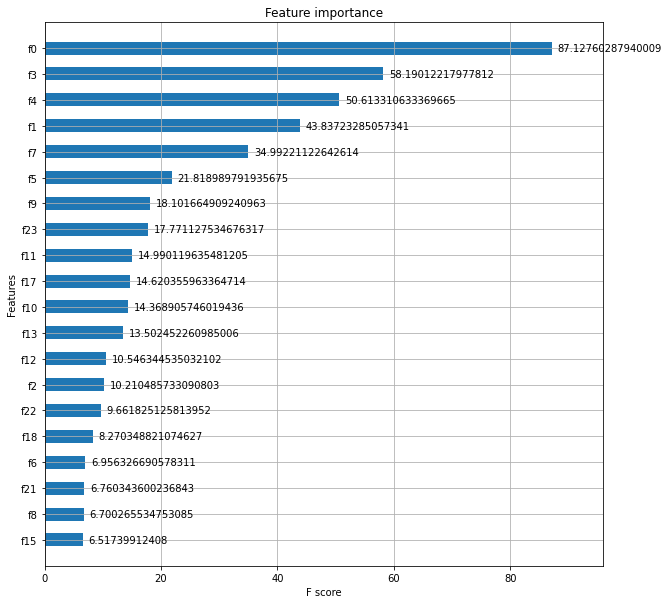

In [288]:
#average loss reduction gained when using this feature for splitting in trees.
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax,importance_type='gain')
plt.show()

The model says that is used game_time mean 557 times to split the data across the trees.

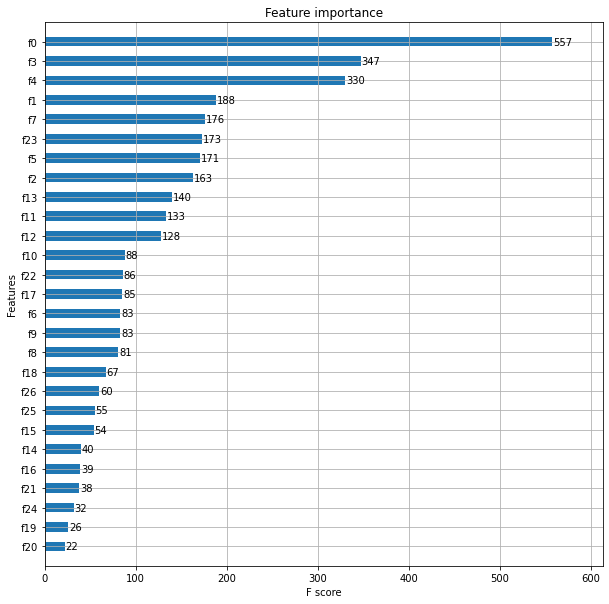

In [286]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax,importance_type='weight')
plt.show()

In [ ]:
pip install shap

**Feature importance with shap**

https://christophm.github.io/interpretable-ml-book/index.html

https://github.com/slundberg/shap

https://www.kaggle.com/shahules/xgboost-feature-selection-dsbowl/comments

https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407

https://www.kaggle.com/dansbecker/shap-values


SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

While SHAP can explain the output of any machine learning model.

A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions
You'll use SHAP Values to explain individual predictions in this lesson. In the next lesson, you'll see how these can be aggregated into powerful model-level insights.

In [308]:
#initialize shap values
import shap
model=train_model(X_train_pca, y_train, {})
shap_values = shap.TreeExplainer(model).shap_values(X_train_pca)

X shape is:(7352, 27)
y shape is:(7352,)
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}
Accuracy @ train: 0.9464091403699674


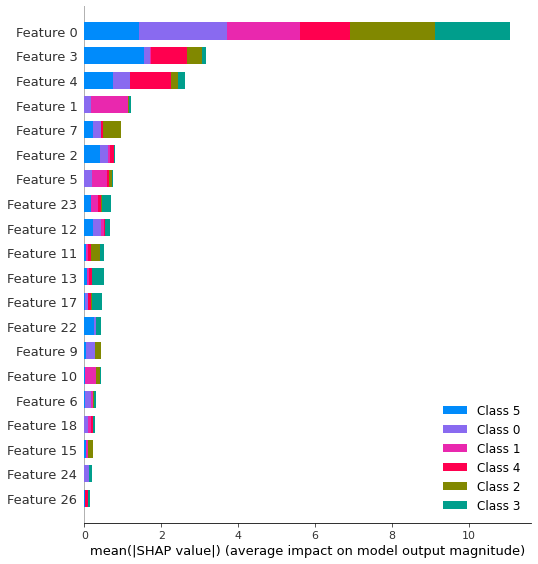

In [310]:
shap.summary_plot(shap_values, X_train_pca, plot_type="bar")

For feature 3 its SHAP value is high for class 5 means it influences predicting class 3 is more than any other class.

Summary plot for class 3

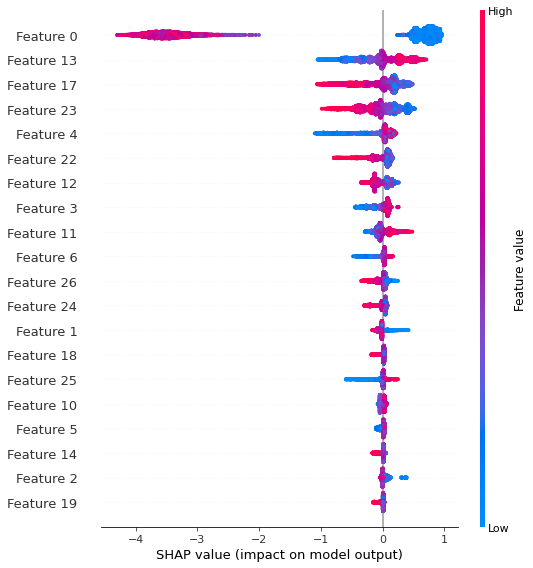

In [290]:
shap.summary_plot(shap_values[3], X_train_pca)

Here we can see that the variables are ranked in the descending order.

The most important variable Feature 0.
Lower value of Feature 0 has a high and positive impact on the model predicting class 3. Lower value of event_code_3020 the model tends to classify it to class 3

Summary plot for class 0:

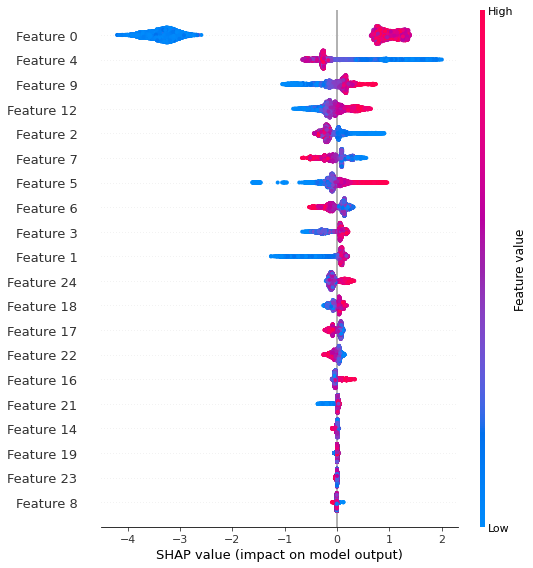

In [292]:
shap.summary_plot(shap_values[0], X_train_pca)

Lower value of Feature 0 tends it to NOT classifying it by Class 0

Источники:



#@Экспериментальный код

https://stackoverflow.com/questions/47152610/what-is-the-difference-between-xgb-train-and-xgb-xgbregressor-or-xgb-xgbclassif


In [59]:
#params usage
#params = {'eta':1, 'objective':'binary:logistic' }
#params={'n_estimators':1000, 'learning_rate':0.05}
#'n_estimators=1000, learning_rate=0.05'
params = {'objective':'binary:logistic', 'n_estimators':10, 'learning_rate':0.05}
run_model(X_train_pca, y_train, params)

X shape is:(7352, 27)
y shape is:(7352,)

Targets are:  [4. 5. 5. ... 2. 2. 2.]
Accuracy: 0.8254896626768227
Classification report:
              precision    recall  f1-score   support

         1.0       0.80      0.88      0.83      1226
         2.0       0.82      0.81      0.82      1073
         3.0       0.86      0.78      0.82       986
         4.0       0.81      0.60      0.69      1286
         5.0       0.74      0.90      0.81      1374
         6.0       0.95      0.96      0.95      1407

    accuracy                           0.83      7352
   macro avg       0.83      0.82      0.82      7352
weighted avg       0.83      0.83      0.82      7352



Train score:

In [55]:
#default params
run_model(X_train_pca, y_train,params)

X shape is:(7352, 27)
y shape is:(7352,)

Targets are:  [5. 5. 5. ... 2. 2. 2.]
Accuracy: 0.9983677910772579
Classification report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1226
         2.0       1.00      1.00      1.00      1073
         3.0       1.00      1.00      1.00       986
         4.0       1.00      0.99      1.00      1286
         5.0       0.99      1.00      1.00      1374
         6.0       1.00      1.00      1.00      1407

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352



In [ ]:
# YOUR CODE HERE

Test score:

Good result on test data with default parameters

In [131]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_boston

# Grid Search Parameters
grid_search_params = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [100],
    'subsample': [0.2, 0.5, 0.8],
    'max_depth': [2, 3, 5]
}

xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")

grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error',
                    cv=4, verbose=1, iid=True)

grid.fit(X_test_pca, y_test)
print("GridSearchCV")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  1.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.2}
Lowest RMSE found:  0.5430790666068437


https://stackoverflow.com/questions/47152610/what-is-the-difference-between-xgb-train-and-xgb-xgbregressor-or-xgb-xgbclassif